<div class="alert alert-block alert-warning">
<b>REQUIREMENT:</b> Before running any code, please be sure you have installed or updated to the latest version of <a href="https://astroconda.readthedocs.io/en/latest/" target="new" class="alert-link">AstroConda</a>.
</div>

# Calculating ACS Zeropoints

## Introduction

***

While we can use [PySynphot](http://pysynphot.readthedocs.io/en/latest/) to estimate the aperture corrections, it is best to measure these values from a selection of isolated point sources in your data. In the example below, we have used the PySynphot method. These examples give the same results as the  [Zeropoint Calculator](https://acszeropoints.stsci.edu).

Aperture corrections from 0.5 and 1.0 arcseconds to "infinity" can be found on the [Aperture Corrections](http://www.stsci.edu/hst/acs/analysis/apcorr) webpage. These tables are a collection of information from several publications and include information for all ACS cameras (WFC, SBC, and HRC). For ACS, the "infinite" aperture corresponds to a radius of 5.5 arcseconds.

Recall that the appropriate `PHOTFLAM` and `PHOTPLAM` values for a given observation can be found in the SCI extention headers of every ACS image.

### This tutorial will show you how to...

#### 1. Set up stsynphot

* Download
* Update path
* Install

#### 1. [Understand Basic Photometric Systems](#_systems)

* Flux 
* VegaMag
* ABMag
* STMag

#### 2. [Understand Photometry Keywords in ACS Images](#_keywords) 

* Use `astroquery` to download data products from the *HST* archive using a known dataset name

#### 3. [Calculate Zeropoints](#_zeropoint) 

* Use `astroquery` to download data products from the *HST* archive using a known dataset name

#### 4. [Convert Between Instrumental and Physical Fluxes/Magnitudes](#_convert)

* Use `AstroDrizzle` with ASN files to combine images.

## Imports

***

Here we list the Python packages used in this notebook. Links to the documentation for each module is provided for convenience.

| Package Name     | module           | docs          | used for    |
|------------------|:-----------------|:-------------:|:------------|
| `os`             | `system`           | <a class="divlink" href="https://docs.python.org/2/library/os.html#os.system">link</a>|command line input|
| `os`             | `environ`          | <a class="divlink" href="https://docs.python.org/2/library/os.html#os.environ">link</a>| setting environments |
|`shutil`          | `rmtree`           | <a class="divlink" href="https://docs.python.org/2/library/shutil.html#shutil.rmtree">link</a>| remove directory tree |
|`glob`            | `glob`             | <a class="divlink" href="https://docs.python.org/2/library/glob.html#glob.glob">link</a>| search for files based on Unix shell rules |
|`astropy.io`      | `fits`             | <a class="divlink" href="http://docs.astropy.org/en/stable/io/fits/">link</a>| access and update fits files
|`astropy.table`   | `Table`            | <a class="divlink" href="http://docs.astropy.org/en/stable/table/">link</a>| constructing and editing in a tabular format
|`numpy`           | `_s`               | <a class="divlink" href="https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.s_.html">link</a>| functions for array handling and operations
|`astroquery.mast` |`Observations`      | <a class="divlink" href="https://astroquery.readthedocs.io/en/latest/mast/mast.html">link</a>| download data from MAST
|`stwcs`           |`updatewcs`         | <a class="divlink" href="https://stwcs.readthedocs.io/en/latest/updatewcs_ui.html">link</a>| update wcs solution
|`drizzlepac`      |`astrodrizzle`      | <a class="divlink" href="https://drizzlepac.readthedocs.io/en/deployment/astrodrizzle.html">link</a>| drizzle combine images
|`acs_pypack`      |`notebook_tools`    | N/A | convenience functions written for the purpose of this notebook
|`matplotlib`      |`pyplot`            | <a class="divlink" href="https://matplotlib.org/api/pyplot_api.html">link</a>| plotting functions
|`matplotlib`      |`colors.LogNorm`    | <a class="divlink" href="https://matplotlib.org/api/_as_gen/matplotlib.colors.LogNorm.html#matplotlib.colors.LogNorm">link</a>| data normalization used for contrast plotting
|`photutils`       |`EllipticalAperture`| <a class="divlink" href="https://photutils.readthedocs.io/en/stable/api/photutils.EllipticalAperture.html">link</a>| construct aperture object for plotting

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table

## Setting up stsynphot

***

Before you begin, you'll need to download the instrument throughput curves that will be used by the Space Telescope Synthetic Photometry package, stsynphot. This can be done through command line input.

In [2]:
cmd_input = 'curl -O ftp://archive.stsci.edu/pub/hst/pysynphot/synphot1.tar.gz'
os.system(cmd_input)

0

Alternatively, you can go to ftp://archive.stsci.edu/pub/hst/pysynphot/ and download `synphot1.tar.gz`.

Once you have downloaded the tar file, we need unpack it and set 'PYSYN_CDBS' to the path of where your unpacked files are.

In [3]:
cmd_input = 'tar -xvf synphot1.tar.gz'
os.system(cmd_input)
os.environ['PYSYN_CDBS'] = './grp/hst/cdbs/'

Now, you can import the package. You may need to install it with pip or conda if you have not already done so.

In [8]:
import stsynphot as stS
import pysynphot as pyS

## Photometric Systems <a id="_systems"></a>

***

Here we define several terms generally used in the photometric analysis of *HST*/ACS observations.

| Term               | Definition                         | Equation             |
|--------------------|:-----------------------------------|:---------------------|
| <b>Flux</b>        | The average flux $F$ in units of erg s$^{-1}$ |
| $F_{\mathrm{Vega}}$| Flux spectrum of Vega|
| <b>VegaMag</b> | Magnitude system where Vega has an apparent magnitude of 0 at all wavelengths.|$m_{\mathrm{Vega}}=-2.5\log_{10}(F/F_{\mathrm{Vega}})$|
| <b>ABMag</b>       | Artificially defined magnitude system with constant flux per unit frequency.|$m_{\mathrm{AB}} = -2.5\log_{10}(F_\nu) - 48.60$|
| <b>STMag</b>       | Artificially defined magnitude with constant flux per unit wavelength |$m_{\mathrm{ST}} = -2.5\log_{10}(F_\lambda) - 21.10$|

## Photometric Keywords in the SCI Extension of ACS Images <a id="_keywords"></a>
***

The following header keywords present in ACS FITS files contain useful photometric calibration information.

| Keyword | Description |
|---------|:------------|
|`PHOTMODE`| Observation configuration for photometric calibration.|
|`PHOTFLAM`| The scaling factor to convert instrumental flux (counts/s) to a physical flux density. The flux in the pivot wavelength that produces 1 count. Units of ergs $\unicode{x212B}^{-1}$cm$^{-2}$ count$^{-1}$.|
|`PHOTZPT`| STMag zeropoint.|
|`PHOTPLAM`| Pivot wavelength. Units of $\unicode{x212B}$.|

The `PHOTFLAM` and `PHOTPLAM` header keywords are used to derive the instrumental zeropoint magnitudes, which are defined to be the magnitude of an object that produces one count per second. The instrumental magnitudes are defined as follows:

* $\mathrm{ZP}_{\mathrm{ST}} = -2.5\log_{10}($ `PHOTFLAM` $) - 21.10$

* $\mathrm{ZP}_{\mathrm{AB}} = -2.5\log_{10}($ `PHOTFLAM` $) - 5\log_{10}($ `PHOTPLAM` $) - 2.408$

## Generating the Data

***

Set up bandpass and source spectrum. Perform a synthetic observation of the source. Note that the term 'counts' in PySynphot is variable for each instrument. For ACS, 'counts' refers to electrons.

By choosing a spectrum that produces a count rate of 1 count/second (we can do this by normalizing our source spectrum), [PySynphot](http://pysynphot.readthedocs.io/en/latest/) can be made to return the VegaMag, STMag, and ABMag zeropoints. First we will generate a blackbody spectrum for an object with a temperature of 10000K

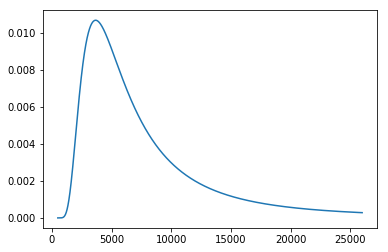

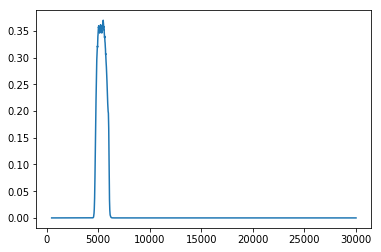

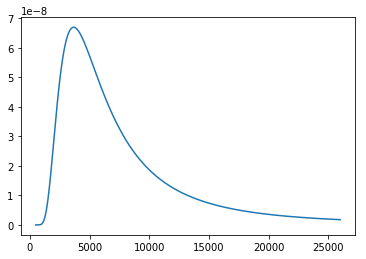

In [57]:
spec_bb = pyS.BlackBody(10000)
plt.plot(spec_bb.wave, spec_bb.flux)
plt.show()

bp = pyS.ObsBandpass('acs,wfc1,f555w,mjd#57754')
plt.plot(bp.wave, bp(bp.wave))
plt.show()

spec_bb_norm = spec_bb.renorm(1, 'counts', bp)
plt.plot(spec_bb_norm.wave, spec_bb_norm.flux)
plt.show()

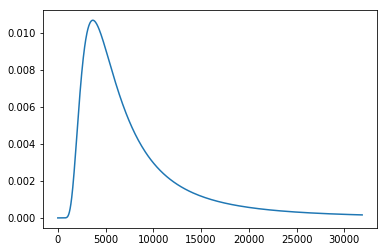

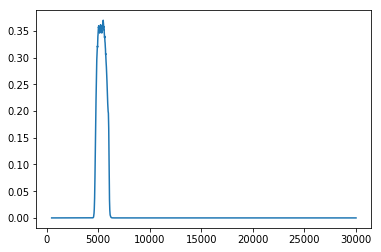

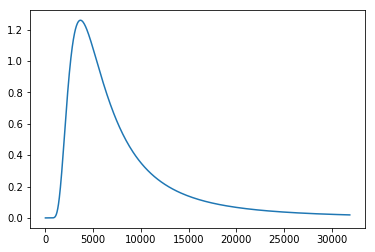

In [58]:
from synphot import SourceSpectrum
from synphot.models import BlackBodyNorm1D

spec_bb = SourceSpectrum(BlackBodyNorm1D, temperature=10000)
plt.plot(spec_bb.waveset,spec_bb(spec_bb.waveset))
plt.show()

bp = stS.band('acs, wfc1, f555w, mjd#57754')
plt.plot(bp.waveset, bp(bp.waveset))
plt.show()

spec_bb_norm = spec_bb.normalize(1, band=bp, wavelengths=bp.waveset)

plt.plot(spec_bb_norm.waveset,
         spec_bb_norm(spec_bb_norm.waveset))

plt.show()

We want to calculate all of the zeropoints (VegaMag, STMag, and ABMag) for a specific date and filter. In this case, we will use Jan 1, 2017 (the MJD of this date is 57754) and the F555W filter. 

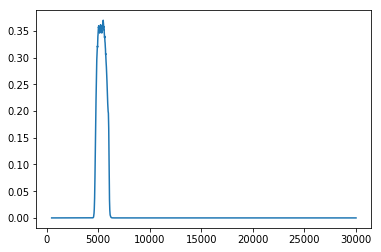

The spectrum is multiplied by a numeric factor so that the total integrated flux will be the given value in the given unit in the given bandpass.

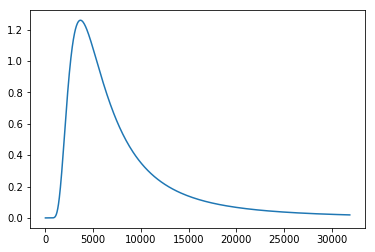

In [51]:
help(spec_bb.renorm)

Help on method renorm in module pysynphot.spectrum:

renorm(RNval, RNUnits, band, force=False) method of pysynphot.spectrum.BlackBody instance
    :ref:`Renormalize <pysynphot-renorm>` the spectrum to the
    specified value, unit, and bandpass.
    
    This wraps :func:`~pysynphot.renorm.StdRenorm` for convenience.
    Basically, the spectrum is multiplied by a numeric factor so that
    the total integrated flux will be the given value in the given
    unit in the given bandpass.
    
    When ``force=False``, if spectrum is not fully defined within the
    given bandpass, but the overlap is at least 99%, a warning is
    printed to screen and ``self.warnings['PartialRenorm']`` is set
    to `True`.
    
    Parameters
    ----------
    RNval : number
        Flux value for renormalization.
    
    RNUnits : str
        Unit name, as accepted by `~pysynphot.units.Units`, for ``RNval``.
    
    band : `SpectralElement`
        Bandpass that ``RNval`` is based on.
    
    force : 

## Calculating the Zeropoints <a id="_zeropoint"></a>

***

Using this information, [PySynphot](http://pysynphot.readthedocs.io/en/latest/) will determine the appropriate `PHOTFLAM` and `PHOTPLAM` values. 

Given a source spectrum, it will also calculate the VegaMag, STMag, and ABMag magnitudes for the source. 

In [ ]:
obs = pyS.Observation(spec_bb_norm, bp)

Now, we can get the photometric calibration information from our specified type of observation

In [ ]:
photflam = obs.effstim('flam') 
photplam = bp.pivot() 

print('PHOTFLAM = {}'.format(photflam))
print('PHOTPLAM = {}'.format(photplam))

Get the magnitudes of the source spectrum in the bandpass. Because the source was normalized to 1 electron per second, the magnitudes are the zeropoints in their respective systems. 

<center>$m_{\mathrm{Vega}}=-2.5\log_{10}(counts)+\mathrm{ZP}_\mathrm{Vega}$</center>

In [ ]:
zp_vega = obs.effstim('vegamag')
zp_st = obs.effstim('stmag')
zp_ab = obs.effstim('abmag')

print('VegaMag_ZP = {}'.format(zp_vega))
print('STMag_ZP = {}'.format(zp_st))
print('ABMag_ZP = {}'.format(zp_ab))

## Converting Between Instrumental and Physical Fluxes/Magnitudes <a id="_convert"></a>
***

In this example, we have a measurement of the fluxes of several point sources in 0.2 arcsecond (4 pixel) radius apertures using the ACS/WFC camera and the F555W filter taken on Jan 1, 2017. We will need to first apply an aperture correction to our measurements and then convert from the instrumental units of electrons per second to physically meaningful values (e.g., STMag and ABMag).

In [ ]:
instrumental_flux = np.array([5.2393, 7.2935, 3.2355, 4.9368])

Going to the aperture correction table, corrections are available from 0.5" or 1" to infinity (absolute). From the table, we find correction from 0.5" to infinity for the ACS/WFC camera in F555W is 0.915.

In [ ]:
correction_05_to_inf = 0.915

However, since our count rates come from a 0.2" aperture, we'll need to first get the apperture correction from 0.2" to 0.5"

Use the blackbody defined in the previous example to be our source and simulate the count rate in a 0.2" and 0.5" aperture.

In [ ]:
band02 = pyS.ObsBandpass('acs,wfc1,f555w,mjd#57754,aper#0.2')
band05 = pyS.ObsBandpass('acs,wfc1,f555w,mjd#57754,aper#0.5')

obs02 = pyS.Observation(spec_bb, band02)
obs05 = pyS.Observation(spec_bb, band05)

Now we can get our aperture correction!

In [ ]:
correction_02_to_05 = obs02.countrate()/obs05.countrate()
print('Aperture correction 0.2 -> 0.5 = {}'.format(correction_02_to_05))

Now to obtain our estimated absolute flux values, we can apply our the aperture correction from 0.2" to 0.5" to measured fluxes, then apply the correction from 0.5" to infinity.

In [ ]:
flux05 = instrumental_flux / correction_02_to_05
flux_inf = flux05 / correction_05_to_inf

We can recalculate the zeropoints using the PHOTFLAM and PHOTPLAM we calculated earlier

In [ ]:
zp_stmag = -2.5 * np.log10(photflam) - 21.10 
zp_abmag = -2.5 * np.log10(photflam) - (5 * np.log10(photplam)) - 2.408

Now convert instrumental fluxes to physical fluxes and magnitudes. f_lambda is the flux density in units of erg/sec/cm^2/$\unicode{x212B}$.

In [ ]:
f_lambda = flux_inf * photflam
stmags = -2.5 * np.log10(flux_inf) + zp_stmag
abmags = -2.5 * np.log10(flux_inf) + zp_abmag
vegamags = -2.5 * np.log10(flux_inf) + zp_vega

For easier viewing, we can organize the values into an Astropy Table.

In [ ]:
phot_table = Table({'Measured Flux': instrumental_flux, 'F_lambda': f_lambda,
                    'ST Mag': stmags, 'AB Mag': abmags, 'Vega Mag': vegamags},)

phot_table

For more help...

See the [ACS Data Handbook](http://www.stsci.edu/hst/acs/documents/handbooks/currentDHB/acs_cover.html) section [5.1.3](http://www.stsci.edu/hst/acs/documents/handbooks/currentDHB/acs_Ch52.html#94716) for more information.

### References <a id="_references"></a>

***

* [Avila, R. J., Chiaberge, M. 2016, ACS ISR 2016-05](http://www.stsci.edu/hst/acs/documents/isrs/isr1605.pdf)
* [Bohlin, R. C. 2011, ACS ISR 2011-02](http://www.stsci.edu/hst/acs/documents/isrs/isr1102.pdf)
* [Bohlin, R. C. 2012, ACS ISR 2012-01](http://www.stsci.edu/hst/acs/documents/isrs/isr1201.pdf)
* [Bohlin, R. C. 2016, ACS ISR 2016-03](http://www.stsci.edu/hst/acs/analysis/zeropoints/hst/acs/documents/isrs/1603.html)
* [Bohlin, R. C., Mack, J., & Ubeda L. 2011, ACS ISR 2011-03](http://www.stsci.edu/hst/acs/documents/isrs/isr1103.pdf)
* [Tran, D. et al. 2002, "2002 HST Calibration Workshop"](http://www.stsci.edu/hst/HST_overview/documents/calworkshop/workshop2002/CW2002_Papers/tran.pdf)
* [Sirianni, M. et al. 2005, PASP, 117, 1049S](http://adsabs.harvard.edu/abs/2005PASP..117.1049S)